<a href="https://colab.research.google.com/github/jamaalm01/Pairs-Trading-Strategies/blob/main/Pairs_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt


In [28]:
#specifying parameters
stocks = ['JPM','C']
start = '2021-12-31'
end = '2023-12-31'
fee = 0.001
window = 252
t_threshold = -2.5
#retrieving data
data = pd.DataFrame()
returns = pd.DataFrame()
for stock in stocks:
    prices = yf.download(stock, start, end)
    data[stock] = prices['Close']
    returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop=True) - 1 , 0)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


day 2023-01-03 00:00:00

no trading
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 0.0%

day 2023-01-04 00:00:00

no trading
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 0.0%

day 2023-01-05 00:00:00

long position on C and short position on JPM
gross daily return: -0.72%
net daily return: -0.82%
cumulative net return so far: -0.82%

day 2023-01-06 00:00:00

long position on JPM and short position on C
gross daily return: -0.9%
net daily return: -1.1%
cumulative net return so far: -1.91%

day 2023-01-09 00:00:00

long position on JPM and short position on C
gross daily return: -0.47%
net daily return: -0.47%
cumulative net return so far: -2.37%

day 2023-01-10 00:00:00

long position on JPM and short position on C
gross daily return: -0.34%
net daily return: -0.34%
cumulative net return so far: -2.7%

day 2023-01-11 00:00:00

long position on JPM and short position on C
gross daily return: -0.88%
net daily return: -0.88%
cumul

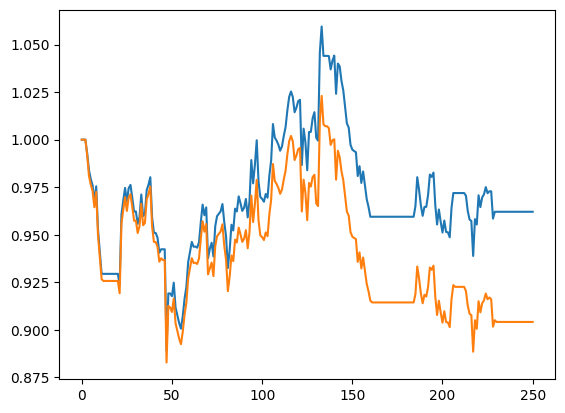

In [29]:
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
stock1 = stocks[0]
stock2 = stocks[1]
#moving through the sample
for t in range(window, len(data)):
    #defining the unit root function: stock2 = a + b*stock1
    def unit_root(b):
        a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t])
        fair_value = a + b*data[stock1][t-window:t]
        diff = np.array(fair_value - data[stock2][t-window:t])
        diff_diff = diff[1:] - diff[:-1]
        reg = sm.OLS(diff_diff, diff[:-1])
        res = reg.fit()
        return res.params[0]/res.bse[0]
    #optimising the cointegration equation parameters
    res1 = spop.minimize(unit_root, data[stock2][t]/data[stock1][t], method='Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])
    #simulating trading
    fair_value = a_opt + b_opt*data[stock1][t]
    if t == window:
        old_signal = 0
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[stock2][t])
        gross_return = signal*returns[stock2][t] - signal*returns[stock1][t]
    fees = fee*abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)
    #interface: reporting daily positions and realised returns
    print('day '+str(data.index[t]))
    print('')
    if signal == 0:
        print('no trading')
    elif  signal == 1:
        print('long position on '+stock2+' and short position on '+stock1)
    else:
        print('long position on '+stock1+' and short position on '+stock2)
    print('gross daily return: '+str(round(gross_return*100,2))+'%')
    print('net daily return: '+str(round(net_return*100,2))+'%')
    print('cumulative net return so far: '+str(round(np.prod(1+net_returns)*100-100,2))+'%')
    print('')
    old_signal = signal
#plotting equity curves
plt.plot(np.append(1,np.cumprod(1+gross_returns)))
plt.plot(np.append(1,np.cumprod(1+net_returns)))
